**BIDS Conversion for LOC EEG Experiment**

This notebook performs the conversion of raw BrainVision EEG data to the BIDS standard for a single participant. The workflow involves reading the raw data, applying a standard 10-20 montage to define sensor positions, mapping experimental annotations to event triggers, and writing the dataset to a BIDS-compliant directory structure.

The BIDS writer automatically creates the correct folder structure (e.g., sub-XX/eeg/), saves all EEG files (.vhdr, .vmrk, .eeg), generates event and channel metadata, CapTrak electrode and coordinate system files, and a sub-XX_scans.tsv file.

In [1]:
import mne # Import the MNE library
import numpy as np

In [ ]:
# Standard library imports
from pathlib import Path

# Third-party imports
from mne.channels import make_standard_montage
from mne_bids import BIDSPath, write_raw_bids


In [3]:
# Only change this one variable to select which file you want to convert to bids
sub_num   = "01"
data_path = Path(r"C:\Users\noahm\projects\loc_analysis\data\raw")
sub_dir = Path(f"pilot_{sub_num}") / "eeg_data"
raw_fname = data_path / sub_dir / f"loc_s{sub_num}.vhdr"

print('Location of raw EEG files:', raw_fname)

Location of raw EEG files: C:\Users\noahm\projects\loc_analysis\data\raw\pilot_01\eeg_data\loc_s01.vhdr


In [ ]:
# Find and read the raw file
raw = mne.io.read_raw_brainvision(raw_fname)

# Print basic info - Does it match the online recording settings?
print(raw.info)

# Get indices of all channels
print("All channel names:")
print(raw.ch_names)

Extracting parameters from C:\Users\noahm\projects\loc_analysis\data\raw\pilot_01\eeg_data\loc_s01.vhdr...
Setting channel info structure...
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 63 EEG, 2 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 280.0 Hz
 meas_date: 2025-12-02 11:40:38 UTC
 nchan: 65
 projs: []
 sfreq: 1000.0 Hz
>
All channel names:
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'HEOG', 'VEOG']


C:\Users\noahm\AppData\Local\Temp\ipykernel_10900\5732366.py:2: RuntimeWarning: The unit for channel(s) HEOG, VEOG has changed from C to V.
  raw.set_channel_types({'HEOG': 'eog', 'VEOG': 'eog'})


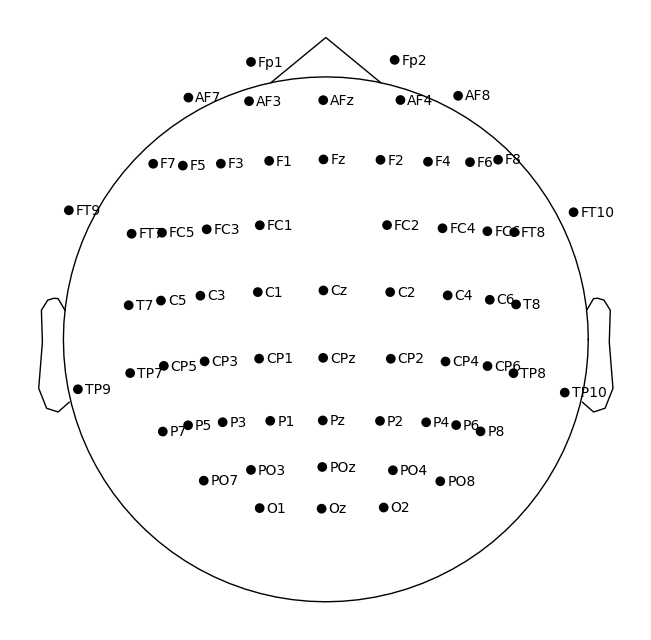

<Annotations | 1219 segments: Stimulus/S 1 (22), Stimulus/S 2 (4), ...>


In [12]:
#Set channels types for the two EOG channels
raw.set_channel_types({'HEOG': 'eog', 'VEOG': 'eog'})

# Define the correct montage for the data available in MNE
montage = make_standard_montage("standard_1020")
raw.set_montage(montage, on_missing='warn') # set the montage to the data file

# 5. Verify montage set-up visually
raw.plot_sensors(show_names=True)

# Check available event keys and if you need to make new ones 
events, event_id = mne.events_from_annotations(raw, verbose=False) # Take the triggers
print(raw.annotations)


The trigger map was specified before implementing the experiment in PsychoPy and is used to recode the numerical trigger codes from the EEG recording back to meaningful event codes.

In [ ]:
trigger_map = {
    'new_segment': 99999,
    # --- EXPERIMENT META ---
    'enc_instr_starts':1,

    # ----------------------------------
    # --- PHASE 0: PRACTICE (2-80) ---
    # ----------------------------------
    'prac_start':2,
    'prac_end':3,

    # ----------------------------------
    # --- PHASE 1: ENCODING (100+) ---
    # ----------------------------------
    'encoding_phase_starts':100,    'enc_act3':105,
    'enc_target':106,
    
    # Encoding Questions
    'enc_prompt':107,
    'enc_resp':108,
    'encoding_phase_ends':199,

    # ----------------------------------
    # -- PHASE 2: DISTRACTOR (50-51) --
    # ----------------------------------
    'dist_start':50,
    'dist_end':51,

    # ----------------------------------
    # --- PHASE 3: RETRIEVAL (200+) ---
    # ----------------------------------
    'ret_instr_start':1,
    'retrieval_phase_starts':200,

    # A. Cues (History of Old Items)
    'ret_cue':201,
    # B. Question 1: "Seen before?"
    'ret_q1_onset':202,
    'ret_q1_resp':203,

    # C. Question 2: "Unexpected?"
    'ret_q2_onset':204,
    'ret_q2_resp':205, 
    # D. Target Selection (4 Choices)
    'ret_q3_onset':206,
    'ret_q3_resp':207,


    'ret_end':43
}

Now, the dataset can be converted into BIDS format. After this code has ran, navigate the newly created directory to ensure that all files were created as expected.

In [14]:
# Remove annotations so I can fill the event_id-s with descriptions
raw.set_annotations(None)

# Set a new root path for the bidsyfied files
#new_path = "/Volumes/Data/ivan/EEG_Woskshop_9_Dec_2025/data/derivatives" # change to own directory
new_path = Path(r"C:\Users\noahm\projects\loc_analysis\data\derivatives")
# change subject number here:
bids_root = Path(new_path)


# Datatype might also be inferred automatically, but it's safer to specify it
bids_path = BIDSPath(
    subject=sub_num,
    datatype="eeg", 
    task="loc",
    root=bids_root
)

# Add extensions to the path
bids_path.update(suffix="eeg", extension=".vhdr")
# Power line frequency missing in raw.info
raw.info["line_freq"] = 50  # required by BIDS. 50Hz in Spain

# Create bids structure for the participant
write_raw_bids(
    raw,
    bids_path=bids_path,
    events=events,
    event_id=trigger_map,
    overwrite=True,
    verbose=True,
)

Extracting parameters from C:\Users\noahm\projects\loc_analysis\data\raw\pilot_01\eeg_data\loc_s01.vhdr...
Setting channel info structure...
Writing 'C:\Users\noahm\projects\loc_analysis\data\derivatives\README'...
Writing 'C:\Users\noahm\projects\loc_analysis\data\derivatives\participants.tsv'...
Writing 'C:\Users\noahm\projects\loc_analysis\data\derivatives\participants.json'...
Writing 'C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-01\eeg\sub-01_space-CapTrak_electrodes.tsv'...
Writing 'C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-01\eeg\sub-01_space-CapTrak_coordsystem.json'...
Used Annotations descriptions: [np.str_('dist_end'), np.str_('dist_start'), np.str_('enc_act1'), np.str_('enc_act2'), np.str_('enc_act3'), np.str_('enc_cue'), np.str_('enc_fixation'), np.str_('enc_prompt'), np.str_('enc_resp'), np.str_('enc_target'), np.str_('encoding_phase_ends'), np.str_('encoding_phase_starts'), np.str_('prac_end'), np.str_('prac_start'), np.str_('ret_cue'), np.st

BIDSPath(
root: C:/Users/noahm/projects/loc_analysis/data/derivatives
datatype: eeg
basename: sub-01_task-loc_eeg.vhdr)